In [ ]:
#pipiline可将任意数量估计器连接到一起
#可以构建一个包含特征提取，体征选择，缩放和分类的管道
#除了最后一步要求所有步骤都具有transform
#调用pipeline.fit的过程中，管道内部依次对每个步骤调用fit和transform，输入是前一个步骤transform的输出，最后一步仅调用fit
#pipeline.steps是由元组组成的列表，pipeline.steps【0】【1】是第一个估计器，pipeline.steps【1】【1】是第二个估计器

In [10]:
def fit(self, X, y):
    X_transformed = x
    for name, estimator in self.steps[:-1]:
        #遍历除最后一步外所有步骤
        #对数据进行拟合和变换
        X_transformed = estimator.fit_transform(X_transformed,y)
    #对最后一步进行拟合
    self.steps[-1][1].fit(X_transformed,y)
    return self

In [11]:
def predict(self,X):
    X_transformed = X
    for step in self.steps[:-1]:
        #遍历除最后一步外所有步骤
        #对数据进行变换
        X_transformed = step[1].transform(X_transformed)
    #利用最后一步进行预测
    return self.steps[-1][1].predict(X_transformed)

In [ ]:
#管道实际上更加通用，最后一步不需要有predict函数，可以对管道调用transform，以得到将PCA.transform处理后的数据，最后一步仅需要具有fit

In [14]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
#标准语法
pipe_long=Pipeline([("scaler",MinMaxScaler()),("svm",SVC(C=100))])
#缩写语法
pipe_short = make_pipeline(MinMaxScaler(),SVC(C=100))

In [15]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe=make_pipeline(StandardScaler(),PCA(n_components=2),StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

#standardscaler带名称

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


In [ ]:
#要想访问管道中的步骤的属性，通过named_steps属性，它是一个字典将步骤名称映射为估计器

In [17]:
#用前面定义的管道对cancer数据集进行拟合
pipe.fit(cancer.data)
#从pca步骤中提取前两个主成分
components=pipe.named_steps["pca"].components_
print("components.shape:{}".format(components.shape))

components.shape:(2, 30)


In [18]:
from sklearn.linear_model import LogisticRegression
pipe=make_pipeline(StandardScaler(),LogisticRegression())

In [20]:
from sklearn.model_selection import GridSearchCV
param_grid={'logisticregression__C':[0.01,0.1,1,10,100]}

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)

print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [22]:
print("Logistic regression step:\n{}".format(grid.best_estimator_.named_steps["logisticregression"]))
#利用named_steps属性访问logisticregression步骤

Logistic regression step:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [23]:
print("Logistic regression coefficients:{}".format(grid.best_estimator_.named_steps["logisticregression"].coef_))
#便于理解系数

Logistic regression coefficients:[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


In [34]:
#将机器学习所有工作流程封装成一个估计，好处在于可以使用监督任务的输出调节预处理参数
#复现boston数据集多项式特征，缩放数据，计算多项式特征，岭回归
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,random_state=0)
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
pipe=make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())
#利用管道搜索degree参数及Ridge的alpha
param_grid={'polynomialfeatures__degree':[1,2,3],'ridge__alpha':[0.001,0.01,0.1,1,10,100]}

grid=GridSearchCV(pipe,param_grid=param_grid,cv=5,n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
         

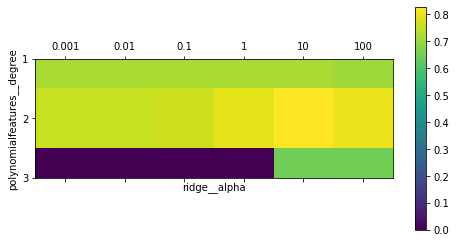

In [35]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3,-1),vmin=0,cmap='viridis')
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])),param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),param_grid['polynomialfeatures__degree'])
plt.colorbar()
#热图可视化

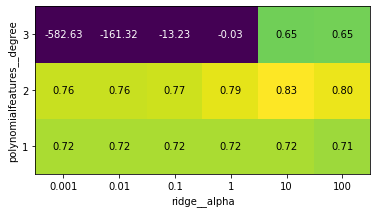

In [37]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [30]:
print("Best parameters:{}".format(grid.best_params_))

Best parameters:{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [31]:
print("Test-set score:{:.2f}".format(grid.score(X_test,y_test)))

Test-set score:0.77


In [32]:
#对照运行一个没有多项式特征的网格搜索：

param_grid={'ridge__alpha':[0.001,0.01,0.1,1,10,100]}
pipe=make_pipeline(StandardScaler(),Ridge())
grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)
print("Test-set score without poly features:{:.2f}".format(grid.score(X_test,y_test)))

#不利用多项式特征得到了更差的结果，gridsearchcv指数增长

Test-set score without poly features:0.63


In [38]:
#尝试搜索在iris数据集上比较随机森林和svc时，使用标准化处理还是不使用
pipe=Pipeline([('preprocessing',StandardScaler()),('classifier',SVC())])
#如果需要跳过管道的某个步骤，可以设置为none
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98


In [ ]:
#pipeline类将多个步骤连接在一起，可将多个步骤封装成python对象
#特别是使用交叉验证进行模型评估与使用网格搜索进行参数选择时，pipeline对正确评估至关重要
#简洁代码，减少错误，要评估模型中的每个组件是否有必要

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import IPython
import sklearn
import mglearn
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

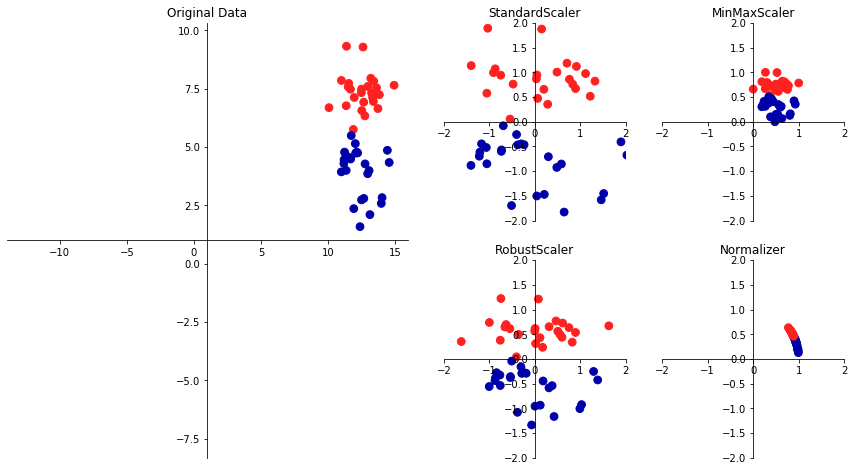

In [5]:
mglearn.plots.plot_scaling()

In [7]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer=load_breast_cancer()
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,random_state=1)

print(X_train.shape)
print(X_test.shape)

(426, 30)
(143, 30)


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [9]:
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [40]:
np.set_printoptions(precision=3, suppress=True)
#变换数据
X_train_scaled = scaler.transform(X_train)
#在缩放前缩放后分别观察数据集属性
print("transformed shape: {}".format(X_train_scaled.shape))
print("per-feature minimum before scaling:\n {}".format(X_train.min(axis=0)))
print("per-feature maximum before scaling:\n {}".format(X_train.max(axis=0)))
print("per-feature minimum after scaling:\n {}".format(X_train_scaled.min(axis=0)))
print("per-feature maximum after scaling:\n {}".format(X_train_scaled.max(axis=0)))

#变换后的数据形状相公，特征发生里移动和缩放
#为应用svm到缩放后的数据上，还需要对测试集进行变化

transformed shape: (426, 30)
per-feature minimum before scaling:
 [  6.981   9.71   43.79  143.5     0.053   0.019   0.      0.      0.106
   0.05    0.112   0.363   0.757   7.228   0.002   0.002   0.      0.
   0.008   0.001   7.93   12.02   50.41  185.2     0.071   0.027   0.
   0.      0.157   0.055]
per-feature maximum before scaling:
 [  28.11    33.81   188.5   2501.       0.145    0.311    0.427    0.201
    0.304    0.097    2.873    4.885   21.98   542.2      0.023    0.106
    0.396    0.053    0.061    0.03    36.04    49.54   251.2   4254.
    0.223    1.058    1.252    0.29     0.664    0.207]
per-feature minimum after scaling:
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.006
 -0.001  0.001  0.     0.001  0.     0.     0.     0.    -0.032  0.
  0.     0.     0.     0.     0.     0.     0.     0.    -0.    -0.002]
per-feature maximum after scaling:
 [1.    0.815 1.    1.    0.831 1.092 1.    1.    1.    1.037 1.    1.
 1.    1.    0.735 0.782 1.    1.

In [41]:
#变换测试数据
X_test_scaled = scaler.transform(X_test)
#打印测试数据变换前后的属性
print("per-feature minimum after scaling:\n{}".format(X_test_scaled.min(axis=0)))
print("per-feature maximum after scaling:\n{}".format(X_test_scaled.max(axis=0)))

#minmaxscaler对测试集应用了与训练集相同的变换，因此有大于1或者小于0

per-feature minimum after scaling:
[ 0.035  0.034  0.029  0.015  0.119  0.055  0.     0.     0.072  0.
 -0.     0.     0.001  0.     0.038  0.011  0.     0.     0.011  0.011
  0.037  0.013  0.034  0.014  0.085  0.021  0.     0.     0.009  0.037]
per-feature maximum after scaling:
[0.768 1.    0.758 0.648 1.    1.22  0.999 0.906 0.932 0.984 0.455 0.726
 0.486 0.317 1.    1.    0.363 0.775 1.337 0.727 0.821 0.876 0.779 0.678
 0.786 0.994 1.    1.    0.921 0.957]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

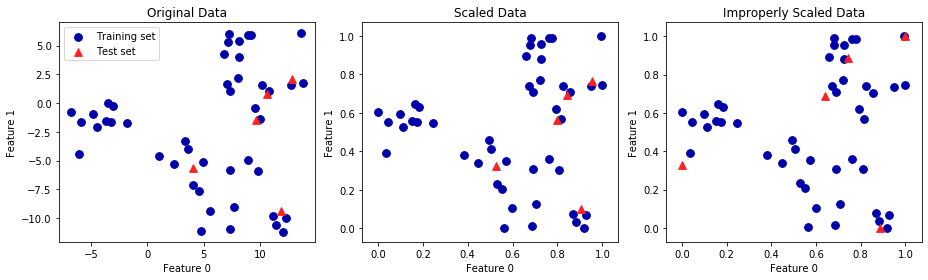

In [42]:
#对比展示同时缩放和分别缩放

from sklearn.datasets import make_blobs
#构造数据
X, _ = make_blobs(n_samples=50, centers=5, random_state=4, cluster_std=2)
#分为测试集和训练集
X_train, X_test = train_test_split(X, random_state=5, test_size=.1)

#绘制训练集和测试集
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
axes[0].scatter(X_train[:, 0], X_train[:, 1],c=mglearn.cm2(0), label="Training set", s=60)
axes[0].scatter(X_test[:, 0], X_test[:, 1], marker='^',c=mglearn.cm2(1), label="Test set", s=60)
axes[0].legend(loc='upper left')
axes[0].set_title("Original Data")

#利用MinMaxScaler缩放数据
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#将正确缩放的数据可视化
axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],c=mglearn.cm2(0), label="Training set", s=60)
axes[1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], marker='^',c=mglearn.cm2(1), label="Test set", s=60)
axes[1].set_title("Scaled Data")

#单独对测试集进行缩放
#测试集的最小值为0，最大值为1
#仅仅为了举例子
test_scaler = MinMaxScaler()
test_scaler.fit(X_test)
X_test_scaled_badly = test_scaler.transform(X_test)

#将错误缩放的数据可视化
axes[2].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],c=mglearn.cm2(0), label="training set", s=60)
axes[2].scatter(X_test_scaled_badly[:, 0], X_test_scaled_badly[:, 1],marker='^', c=mglearn.cm2(1), label="test set", s=60)
axes[2].set_title("Improperly Scaled Data")

for ax in axes:
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
fig.tight_layout()

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#依次调用fit和transform（方法链）
X_scaled = scaler.fit(X_train).transform(X_train)
#结果相同，计算高效
X_scaled_d = scaler.fit_transform(X_train)

In [44]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,random_state=0)
svm = SVC(C=100)
svm.fit(X_train, y_train)
print("Test set accuracy: {:.2f}".format(svm.score(X_test, y_test)))

Test set accuracy: 0.63


In [45]:
# 先用minmaxscaler对数据进行缩放，然后再拟合svc
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#在缩放后的数据上学习svm
svm.fit(X_train_scaled, y_train)

#缩放后的测试集上计算分数
print("Scaled test set accuracy: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Scaled test set accuracy: 0.97


In [46]:
#利用零均值和单位方差的缩放方法进行预处理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#在缩放后的数据上学习svm
svm.fit(X_train_scaled, y_train)

#缩放后的测试集上计算分数
print("SVM test accuracy: {:.2f}".format(svm.score(X_test_scaled, y_test)))

SVM test accuracy: 0.96
